In [1]:
%run notebook_setup

If you have not already read it, you may want to start with the first tutorial: [Getting started with The Joker](1-Getting-started.ipynb).

# Inferring calibration offsets between instruments

Also in addition to the default linear parameters (see [Tutorial 1](1-Getting-started.ipynb), or the documentation for ``JokerSamples.default()``), *The Joker* allows adding linear parameters to account for possible calibration offsets between instruments. For example, there may be an absolute velocity offset between two spectrographs. Below we will demonstrate how to simultaneously infer and marginalize over a constant velocity offset between two simulated surveys of the same "star".

First, some imports we will need later:

In [1]:
import astropy.table as at
import astropy.units as u
import numpy as np
import corner
import pymc as pm
import thejoker.units as xu
import arviz as az

import thejoker as tj

%matplotlib inline

In [2]:
# set up a random number generator to ensure reproducibility
rnd = np.random.default_rng(seed=42)

The data for our two surveys are stored in two separate CSV files included with the documentation. We will load separate `RVData` instances for the two data sets and append these objects to a list of datasets:

In [3]:
data = []
for filename in ["data-survey1.ecsv", "data-survey2.ecsv"]:
    tbl = at.QTable.read(filename)
    _data = tj.RVData.guess_from_table(tbl, t_ref=tbl.meta["t_ref"])
    data.append(_data)

In the plot below, the two data sets are shown in different colors:

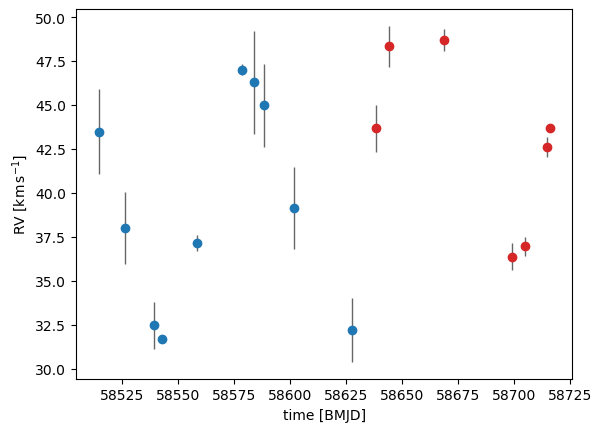

In [4]:
for d, color in zip(data, ["tab:blue", "tab:red"]):
    _ = d.plot(color=color)

To tell *The Joker* to handle additional linear parameters to account for offsets in absolute velocity, we must define a new parameter for the offset betwen survey 1 and survey 2 and specify a prior. Here we will assume a Gaussian prior on the offset, centered on 0, but with a 10 km/s standard deviation. We then pass this in to `JokerPrior.default()` (all other parameters here use the default prior) through the `v0_offsets` argument:

In [5]:
with pm.Model() as model:
    dv0_1 = xu.with_unit(pm.Normal("dv0_1", 0, 10), u.km / u.s)

    prior = tj.JokerPrior.default(
        P_min=2 * u.day,
        P_max=256 * u.day,
        sigma_K0=30 * u.km / u.s,
        sigma_v=100 * u.km / u.s,
        v0_offsets=[dv0_1],
    )

The rest should look familiar: The code below is identical to previous tutorials, in which we generate prior samples and then rejection sample with *The Joker*:

In [6]:
prior_samples = prior.sample(size=1_000, rng=rnd)

In [7]:
joker = tj.TheJoker(prior, rng=rnd)
joker_samples = joker.rejection_sample(data, prior_samples, max_posterior_samples=128)
joker_samples

<JokerSamples [P, e, omega, M0, s, K, v0, dv0_1] (1 samples)>

Note that the new parameter, `dv0_1`, now appears in the returned samples above.

If we pass these samples in to the `plot_rv_curves` function, the data from other surveys is, by default, shifted by the mean value of the offset before plotting:

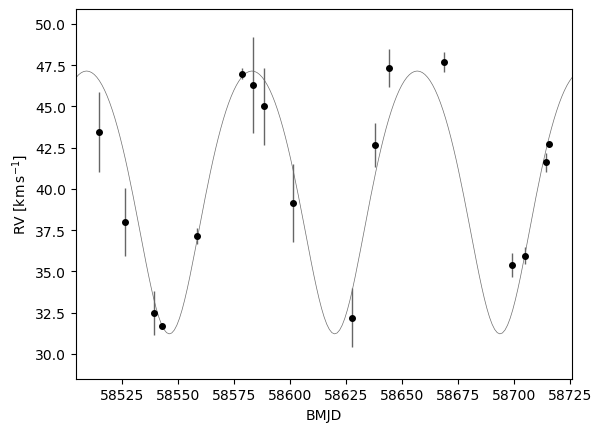

In [8]:
_ = tj.plot_rv_curves(joker_samples, data=data)

However, the above behavior can be disabled by setting `apply_mean_v0_offset=False`. Note that with this set, the inferred orbit will not generally pass through data that suffer from a measurable offset:

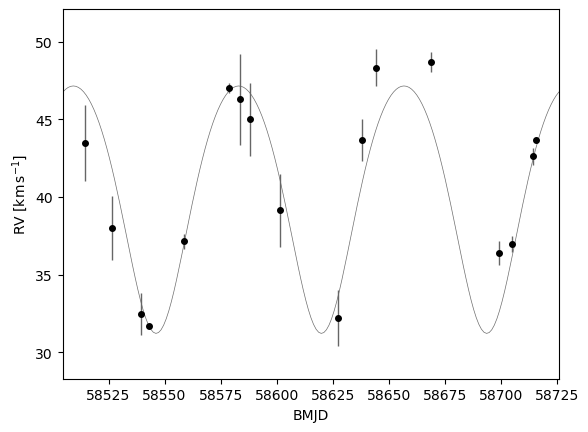

In [9]:
_ = tj.plot_rv_curves(joker_samples, data=data, apply_mean_v0_offset=False)

As introduced in the previous tutorial, we can also continue generating samples by initializing and running standard MCMC:

In [10]:
with prior.model:
    mcmc_init = joker.setup_mcmc(data, joker_samples)

    trace = pm.sample(tune=500, draws=500, start=mcmc_init, cores=1, chains=2)

/var/folders/pj/yn67ml9d7dgd1v5smh0xzb1w0000gn/T/ipykernel_65712/718752178.py:4: FutureWarning: The `start` kwarg was renamed to `initvals` and can now do more. Please check the docstring.
  trace = pm.sample(tune=500, draws=500, start=mcmc_init, cores=1, chains=2)
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Sequential sampling (2 chains in 1 job)
NUTS: [dv0_1, e, __omega_angle1, __omega_angle2, __M0_angle1, __M0_angle2, P, K, v0]


Output()

Output()

Sampling 2 chains for 500 tune and 500 draw iterations (1_000 + 1_000 draws total) took 59 seconds.
We recommend running at least 4 chains for robust computation of convergence diagnostics
The rhat statistic is larger than 1.01 for some parameters. This indicates problems during sampling. See https://arxiv.org/abs/1903.08008 for details
The effective sample size per chain is smaller than 100 for some parameters.  A higher number is needed for reliable rhat and ess computation. See https://arxiv.org/abs/1903.08008 for details


In [11]:
az.summary(trace, var_names=prior.par_names)

/opt/anaconda3/lib/python3.11/site-packages/arviz/stats/diagnostics.py:592: RuntimeWarning: invalid value encountered in scalar divide
  (between_chain_variance / within_chain_variance + num_samples - 1) / (num_samples)


,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
P,77.000,0.549,76.016,78.026,0.032,0.023,285.0,513.0,1.00
e,0.057,0.046,0.000,0.145,0.003,0.002,232.0,366.0,1.00
omega,-0.349,1.663,-3.038,2.232,0.656,0.487,10.0,363.0,1.16
M0,-1.082,2.101,-3.140,2.892,0.159,0.135,290.0,540.0,1.01
s,0.000,0.000,0.000,0.000,0.000,0.000,1000.0,1000.0,NaN
K,-0.010,7.769,-8.018,8.020,5.448,4.600,3.0,216.0,1.83
v0,39.489,0.231,39.076,39.935,0.012,0.008,370.0,526.0,1.01
dv0_1,4.328,0.460,3.512,5.204,0.028,0.019,277.0,520.0,1.01


Here the true offset is 4.8 km/s, so it looks like we recover this value!

A full corner plot of the MCMC samples:

In [12]:
mcmc_samples = tj.JokerSamples.from_inference_data(prior, trace, data)
mcmc_samples = mcmc_samples.wrap_K()

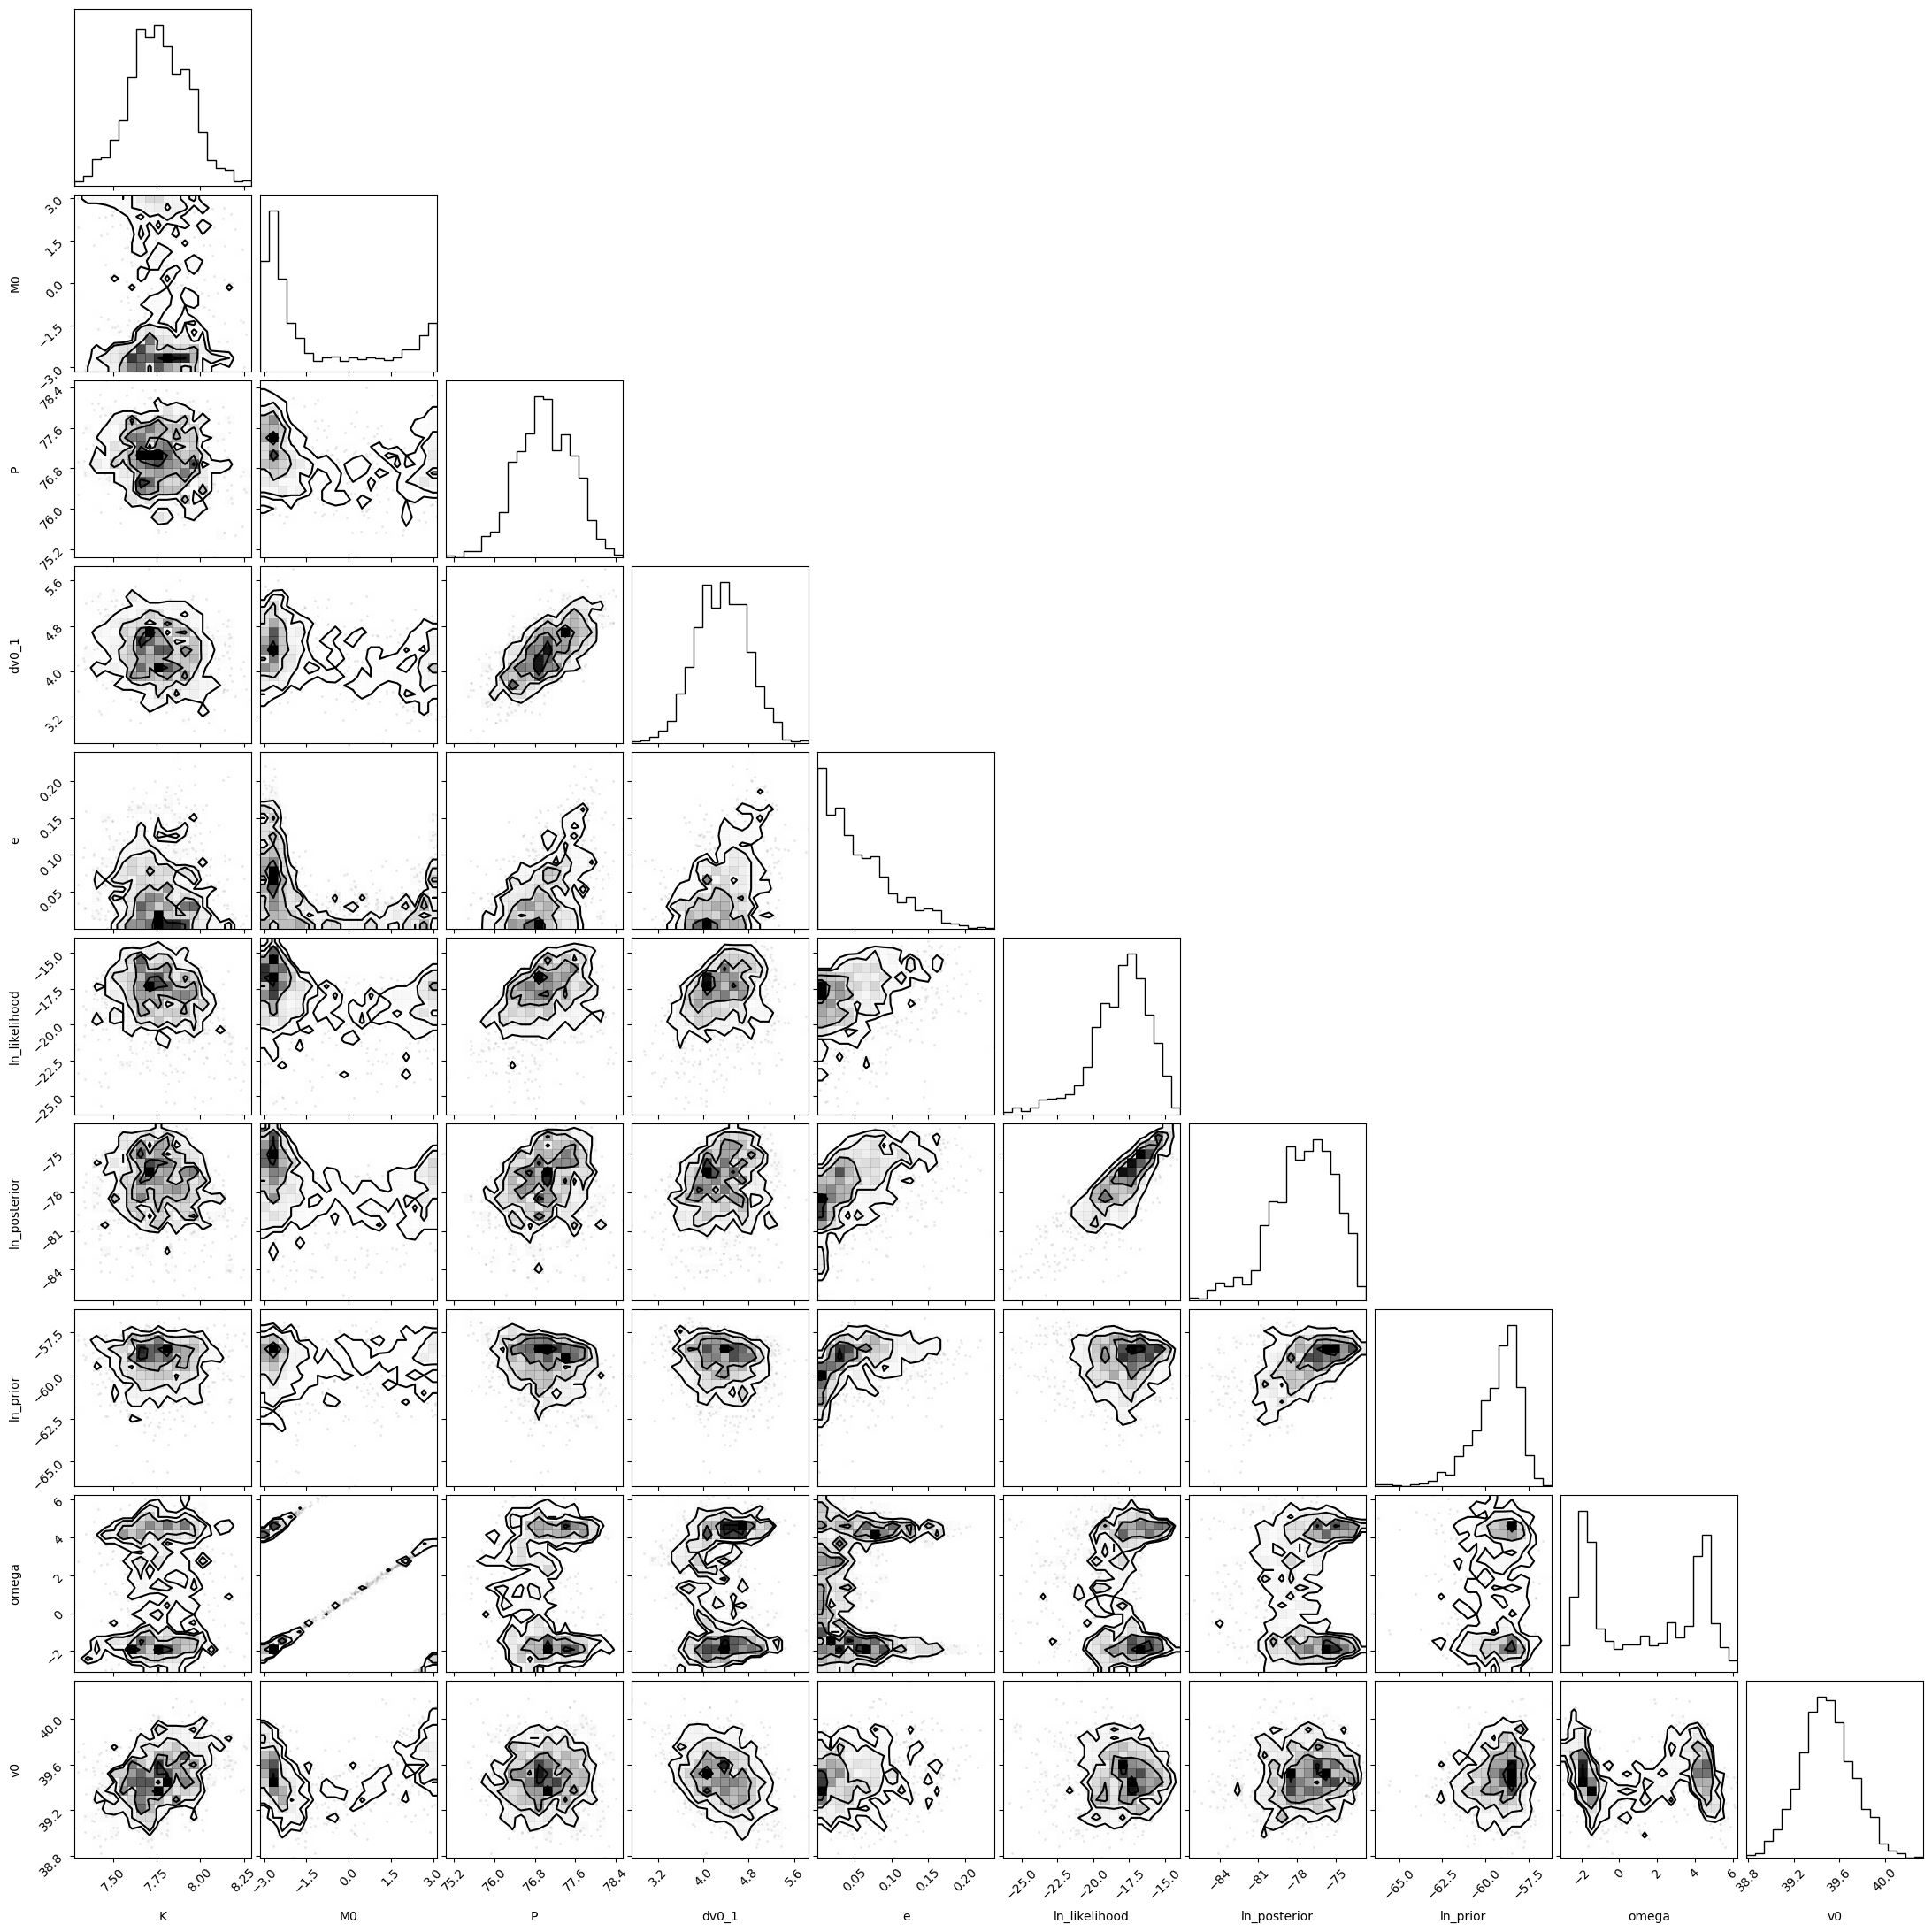

In [13]:
df = mcmc_samples.tbl.to_pandas()
colnames = mcmc_samples.par_names
colnames.pop(colnames.index("s"))
_ = corner.corner(df[colnames])